In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

class Operation:
    def __init__(self, forward, backward, eta=None, weights=None, fweights=None):
        self.in_vars = None;     self.out_vars = None
        self.in_error = None;    self.out_error = None
        self.fforward = forward; self.fbackward = backward
        self.eta = eta
        
        self.weights = weights;  self.fweights = fweights
        self.weight_update = None
        
        if self.weights is not None:
            self.weights = np.array(self.weights)
            if self.fweights is None:
                raise Exception("need to pass weight derivative")
            else:
                self.fweights = np.array(self.fweights)
            
            if self.weights.shape != self.fweights.shape:
                raise Exception("shape of weights and fweights not same")

    def forward(self):
        if self.in_vars is None:
            raise Exception("forward input not initialized")
        self.in_vars = np.array(self.in_vars)
        if self.weights is None:
            self.out_vars = np.array(self.fforward(self.in_vars))
        else:
            self.out_vars = np.array(self.fforward(self.in_vars, self.weights))
    
    def backward(self, weight_index=None):
        if self.in_error is None:
            raise Exception("backward input not initialized")
        if self.out_vars is None:
            raise Exception("do a forward pass first")
        self.in_error = np.array(self.in_error)
        if self.weights is None:
            self.out_error = np.array(self.fbackward(self.in_vars) * self.in_error)
        else:
            self.out_error = np.array(self.fbackward(self.in_vars,self.weights) * self.in_error)
        
        self.update()
        
    def grad_descent(self):
        w = self.weights
        fw = self.fweights
        #dw = np.array([fw.flatten()[i](self.in_vars[:,i],self.weights) for i in np.arange(np.size(fw))])
        #dw = dw.reshape(fw.shape)
        
        dw = np.array(fw[0](self.in_vars,self.weights))
        return self.weights - np.sum(self.eta * dw * self.in_error,0)
    
    def update(self):
        if self.weights is None:
            return
        self.weights = self.grad_descent()
        
class Path:
    def __init__(self, ops, inputs, labels):
        self.ops = ops
        self.inputs = np.array(inputs)
        self.labels = np.array(labels)
        self.risk = None
        self.risk_error = None
        if self.inputs.shape != self.labels.shape:
            raise Exception("inputs and labels need to have same dimensions")
        
    def forward_risk(self,pred,label):
        return np.sum((pred - label)**2) / np.size(pred) / 2
    
    def backward_risk(self,risk,risk_input):
        return np.sum(self.ops[-1].out_vars - self.labels) / np.size(self.labels)
    
    def forward(self):
        self.ops[0].in_vars = self.inputs
        for n, op in enumerate(self.ops[:-1]):
            op.forward()
            self.ops[n+1].in_vars = op.out_vars
            
        self.ops[-1].forward()
        self.risk = self.forward_risk(self.ops[-1].out_vars, self.labels)
        return [self.ops[-1].out_vars, self.risk]
    
    def backward(self):
        if self.risk is None:
            raise Exception("run forward pass first")

        self.risk_error = self.backward_risk(self.risk,self.ops[-1].out_vars)
        self.ops[-1].in_error = self.risk_error
        
        for n, op in reversed(list(enumerate(self.ops))[1:]):
            op.backward()
            self.ops[n-1].in_error = op.out_error

        self.ops[0].backward()




Param A: [2.91472788]
Param B: [0.34418561]
Loss: 0.023059549926775395


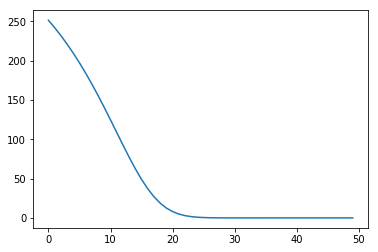

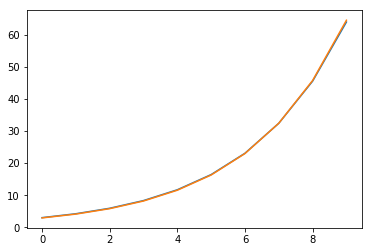

In [14]:
# Generate labels: y=Ae^(Bx)
# x: inputs, y: labels
A = 3; B = 0.34
x = np.arange(10)
y = A*np.exp(B*x)
# y += random.uniform(len(y),0.5)     # add some noise to label

# Define operations
# op1: y=B*x, op2: y=e^x, op3: y=A*x
op1 = Operation(lambda x,w: np.array(x)*w,   lambda x,w: w,  0.000001,   [0.2],  [lambda x,w: x])    # B
op2 = Operation(lambda x  : np.exp(x),       lambda x  : np.exp(x))               
op3 = Operation(lambda x,w: np.array(x)*w,   lambda x,w: w,  0.0001,     [2],    [lambda x,w: x])    # A

# Link operations together in a path
# x -> op1 -> op2 -> op3 -> euclideanloss(x,y)
p = Path([op1,op2,op3],x,y)

loss = []   # empty list to store loss values as training progresses

# Perform 50 iterations of gradient descent
for i in np.arange(50):
    new = p.forward()
    p.backward()
    loss.append(new[1])

plt.plot(loss)

y_hat = new[0]  # this stores the final output by the model
plt.figure()    # plot labels and model predictions in a separate figure
plt.plot(x,y);
plt.plot(x,y_hat);

print("Param A: " + str(op3.weights))
print("Param B: " + str(op1.weights))
print("Loss: " + str(loss[-1]))

In [15]:
class BasicModel:
    
    def __init__(self):
        self.A = Operation(lambda x,w: np.array(x)*w,   lambda x,w: w,  0.0001,     [2],    [lambda x,w: x])
        self.B = Operation(lambda x,w: np.array(x)*w,   lambda x,w: w,  0.000001,   [0.2],  [lambda x,w: x])
        self.op = Operation(lambda x  : np.exp(x),       lambda x  : np.exp(x))
        self.p = None
        
    def fit(self, x, y, A=3, B=0.34, theta=0.0001):
        self.p = Path([self.B, self.op, self.A], x, y)
        loss = []
        
        for i in range(50):
            new = self.p.forward()
            if loss:
                prev = loss[-1]
                if (max(new[1], prev) - min(new[1],prev)) < theta:
                    break
            self.p.backward()
            loss.append(new[1])
        print("A: {}".format(self.A.weights))
        print("B: {}".format(self.B.weights))
        print("Loss: {}".format(loss[-1]))
    
    def predict(self, x):
        if not p:
            raise ValueError("Model is not fitted")
        A = self.A.weights
        B = self.B.weights
        y = A*np.exp(B*x)
        return y

In [16]:
b = BasicModel()

In [17]:
A = 3; B = 0.34
x = np.arange(10)
y = A*np.exp(B*x)
# y += random.uniform(len(y),0.5)

b.fit(x, y)

A: [2.9147088]
B: [0.34418178]
Loss: 0.022827144126779556
